# Image restoration using autoencoder
### by Utsav Dey CS20S009

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim


Util Functions to add gaussian noise and speckle noise.

In [2]:

def add_gaussian_noise(img, row, col):
  mean=0
  var=.1
  sigma=var**.5
  noise=np.random.normal(mean,var,img.shape)
  noise=noise.reshape(row,col)
  img=img+noise
  return img

def add_speckle_noise(img, row, col):
  noise=np.random.randn(row,col)
  noise=noise.reshape(row,col)
  img=img+img*noise
  return img

def add_noise(img,noise_type="gaussian"):
  row,col=28,28
  img=img.astype(np.float32)
  if noise_type=="gaussian":
    return add_gaussian_noise(img, row, col)
  if noise_type=="speckle":
    return add_speckle_noise(img, row, col)




Load MNIST data

In [3]:
(train,_),(test,_)=mnist.load_data()
print(f"No of training datapoints:{len(train)}\nNo of Test datapoints:{len(test)}")

11501568/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


Normalize the data by scaling them by 255.

In [4]:
train , test = train/255.0 , test/255.0

Create noisy data.

In [5]:
noises=["gaussian","speckle"]
traindata = [np.expand_dims(add_noise(x,noise_type=noises[i%2]),axis=0) for i,x in enumerate(train)]
testdata = [np.expand_dims(add_noise(x,noise_type=noises[i%2]),axis=0) for i,x in enumerate(test)]

Plot to see what the training and target image looks like.

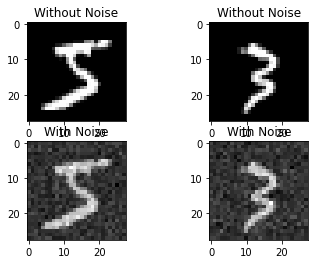

In [6]:

f, axes=plt.subplots(2,2)

for i,img_index in enumerate((0,25000)):
    axes[0,i].imshow(train[img_index],cmap="gray")
    axes[0,i].set_title("Without Noise")
    axes[1,i].imshow(np.squeeze(traindata[img_index]),cmap='gray')
    axes[1,i].set_title("With Noise")



In [7]:
import torch
device = "cuda:0" if torch.cuda.is_available()==True else "cpu"

Create a dataset class , where I am converting the image to correct dimension tensor. 1->channel,1x28*28 is the image vector row and column.

In [8]:
class data(Dataset):
  def __init__(self,original,target):
    self.noise=original
    self.clean=target
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    X=torch.tensor(self.noise[idx]).view(1,1,28*28).to(device)
    Y=torch.tensor(self.clean[idx]).view(1,1,28*28).to(device)

    return (X,Y)
      
  
    

Create train data loader and test dataloader

In [9]:
batch_size=32
trainset=data(traindata,train)
testset=data(testdata,test)
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)

Define the model.

In [10]:

class CNNAutoEncoder(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    self.encoder=nn.Sequential(
                  nn.Conv2d(in_channels=1,out_channels = 16, kernel_size = (3, 3),padding=1),
                  nn.LeakyReLU(),
                  nn.MaxPool2d((2, 2),padding=1),
                  nn.Conv2d(in_channels=16,out_channels = 8, kernel_size = (3, 3),padding=1),
                  nn.MaxPool2d((2, 2),padding=1),
                  nn.Conv2d(in_channels=8,out_channels = 8, kernel_size = (3, 3),padding=1),
                  nn.LeakyReLU(),
                  nn.MaxPool2d((2, 2),padding=1),
                  )
    
    self.decoder=nn.Sequential(
                  nn.Conv2d(in_channels=8,out_channels = 8, kernel_size = (3, 3),padding=1),
                  nn.LeakyReLU(),
                  nn.Upsample(scale_factor=2, mode='nearest'),
                  nn.Conv2d(in_channels=8,out_channels = 8, kernel_size = (3, 3),padding=1),
                  nn.Upsample(scale_factor=2, mode='nearest'),
                  nn.Conv2d(in_channels=8,out_channels = 16, kernel_size = (3, 3),padding=1),
                  nn.LeakyReLU(),
                  nn.Upsample(scale_factor=2, mode='nearest'),
                  nn.Conv2d(in_channels=16,out_channels = 1, kernel_size = (3, 3),padding=1),
                  nn.Flatten(),
                  nn.Linear(792*8,784),
                  nn.Sigmoid(),
                 
                  
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x
  

In [11]:
model=CNNAutoEncoder().to(device)
model=model.float()

In [12]:
x,y=next(iter(trainloader))

Sanity check for everything.

In [13]:
print(f'Shape X - {x.shape} and shape of Y - {y.float().shape} and shape of output - {model(x.float()).shape}')

Shape X - torch.Size([32, 1, 1, 784]) and shape of Y - torch.Size([32, 1, 1, 784]) and shape of output - torch.Size([32, 784])


In [14]:
criterion=nn.MSELoss(reduction='mean')
criterion(torch.squeeze(model(x.float())),torch.squeeze(y.float()))

tensor(0.2322, device='cuda:0', grad_fn=<MseLossBackward0>)

Validation Loop

In [15]:
def validate():
    i=0
    cum_loss=0
    model.eval()
    for x,y in testloader:
        with torch.no_grad(): 
            output=model(x.float())
            cum_loss+=criterion(output,y.float()).item()
    return cum_loss/float(len(testloader))

Train loop.

In [16]:

optimizer=optim.Adam(model.parameters(),lr=0.001)
epochs=10
n=len(trainloader)
cum_loss=0
def train(optimizer, epochs, n):
    for epoch in range(epochs):
        model.train()
        cum_loss=0
        for x,y in trainloader:
          output=model(x.float())
          loss=criterion(torch.squeeze(output),torch.squeeze(y.float()))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          cum_loss+=loss.item()
        print(f'{epoch}/{epochs} done : Loss:{cum_loss/n},Validation Loss:{validate()}')

train(optimizer, epochs, n)


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 1, 784])) that is different to the input size (torch.Size([1, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/10 done : Loss:0.020286620442569257,Validation Loss:0.009586703863728325
1/10 done : Loss:0.008161365888267755,Validation Loss:0.007136118776065996
2/10 done : Loss:0.006611467854678631,Validation Loss:0.006047994114394532
3/10 done : Loss:0.005831800369918347,Validation Loss:0.005572692942916182
4/10 done : Loss:0.005347216849277417,Validation Loss:0.0053006029291893355
5/10 done : Loss:0.005003036939601103,Validation Loss:0.005035553058207734
6/10 done : Loss:0.0047504163168370726,Validation Loss:0.0048774687503173484
7/10 done : Loss:0.00455745488293469,Validation Loss:0.004671262519498123
8/10 done : Loss:0.004404740373169382,Validation Loss:0.0047860496111563405
9/10 done : Loss:0.004263671205565333,Validation Loss:0.00452182841776812


See the output.

Text(0.5, 1.0, 'Actual')

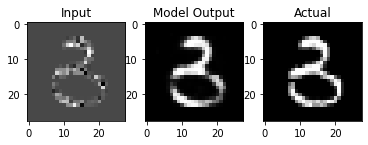

In [17]:



x,y=next(iter(testloader))
f, axes=plt.subplots(1,3)


axes[0].imshow(x.cpu().detach().reshape(28,-1),cmap='gray')
axes[0].set_title("Input")
axes[1].imshow(model(x.float()).cpu().detach().reshape(28,-1),cmap="gray")
axes[1].set_title("Model Output")
axes[2].imshow(y.detach().cpu().reshape(28,-1),cmap='gray')
axes[2].set_title("Actual")




In [18]:
!pwd


/kaggle/working


In [19]:

torch.save(model,'/kaggle/working/denoising_image.pth')  